In [1]:
import sys
from pathlib import Path
from tqdm import tqdm
from shutil import copy, rmtree
import pandas as pd
from datasets import load_dataset
from numpy.random import choice

sys.path.append(str(Path("..").resolve()))
from src import *

/leonardo_scratch/fast/IscrC_MACRO/Texture-Anything/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare dataset for ControlNet training

##### ℹ️ This notebook requires the triplets `uv`, `caption` and `diffuse` for each dataset considered

In this notebook we move all the generated triplets to a single folder, compliant with `ImageFolder` dataset. See more at [Create an image dataset](https://huggingface.co/docs/datasets/image_dataset#imagefolder)

In [6]:
MAX_DATASET_SIZE = 1_000
TEST_SET_RATIO = 0.01  # diffusers train script doesn't use a test set
OUTPUT_PATH = Path("dataset").resolve()
VALIDATION_UIDS = [
    "ffebd77d0373462eb7c6d2d4941eb39c",
    "0a2ad73285bc44d7a4362f54f5de3cc4",
    "0adf456c59094a3da23329a6d27cb239",
    "0cde463ba5d64acd979ab2d4e31fded0",
    "3b15c410f87f42daa7e8cb5b5f74e3f1",
]

In [11]:
datasets: list[Dataset3D] = [ObjaverseDataset3D()]

In [12]:
train_dir, test_dir, valid_dir = "train", "test", "validation"
for dir in [train_dir, test_dir, valid_dir]:
    rmtree(OUTPUT_PATH / dir, ignore_errors=True)
    for folder in ["diffuse", "uv"]:
        (OUTPUT_PATH / dir / folder).mkdir(parents=True, exist_ok=True)

metadata = pd.DataFrame(columns=["uv_file_name", "diffuse_file_name", "caption", "split"])
for dataset in datasets:
    valid_uids = dataset.statistics["valid"].index
    avail_uids = dataset.triplets
    uids = list(avail_uids.intersection(valid_uids))
    if MAX_DATASET_SIZE:
        uids = list(set(uids[:MAX_DATASET_SIZE] + VALIDATION_UIDS))
    test_uids = choice(uids, size=int(len(uids) * TEST_SET_RATIO), replace=False)
    cprint(f"yellow:{dataset.__class__.__name__}", "has", len(avail_uids), "uids,", len(uids), "of them are valid.")

    uv_paths = {x.stem: x for x in (dataset.DATASET_PATH / "uv").glob("*") if x.suffix in dataset.IMG_EXT}
    diffuse_paths = {x.stem: x for x in (dataset.DATASET_PATH / "diffuse").glob("*") if x.suffix in dataset.IMG_EXT}
    captions = dataset.captions

    for uid in tqdm(uids):
        split = test_dir if uid in test_uids else valid_dir if uid in VALIDATION_UIDS else train_dir
        copy(uv_paths[uid], OUTPUT_PATH / split / "uv")
        copy(diffuse_paths[uid], OUTPUT_PATH / split / "diffuse")
        metadata.loc[-1] = [
            "uv/" + uv_paths[uid].name,
            "diffuse/" + diffuse_paths[uid].name,
            captions[uid],
            split,
        ]
        metadata.index += 1
for dir in [train_dir, test_dir, valid_dir]:
    metadata[metadata["split"] == dir].drop(columns=["split"]).to_csv(OUTPUT_PATH / dir / "metadata.csv", index=False)

ObjaverseDataset3D has 13,700 uids, 1,001 of them are valid.


100%|██████████| 1001/1001 [00:05<00:00, 177.72it/s]


In [13]:
size = sum(f.stat().st_size for f in (OUTPUT_PATH).glob("**/*") if f.is_file())
cprint("Dataset size:", size // 1024**2, "green:MiB")

Dataset size: 706 MiB


Generating train split: 986 examples [00:00, 22611.05 examples/s]
Generating validation split: 5 examples [00:00, 1098.16 examples/s]
Generating test split: 10 examples [00:00, 2284.35 examples/s]


Dataset has 986 train samples, 10 test samples, 5 validation samples,


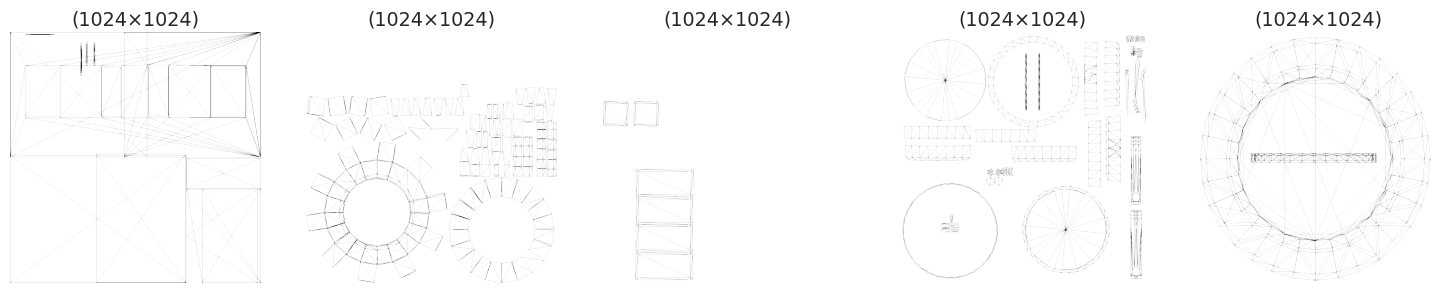

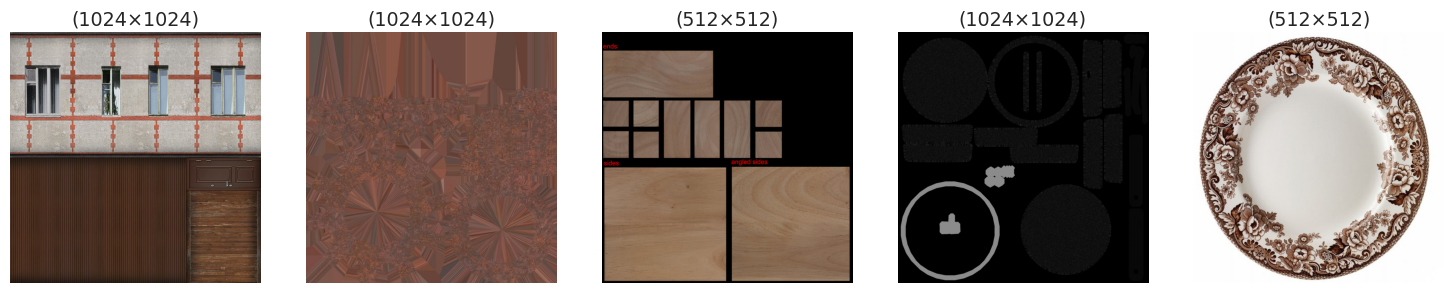

- a rustic wooden house with a dark brown shingled roof and a white stucco exterior with red cross patterns.
- a dark brown, metallic gear with a rough, industrial texture, featuring sharp teeth and a central hole, suggesting a robust and durable design.
- a wooden block with a smooth, polished surface and a light brown color, showcasing a natural wood grain pattern.
- a black non-stick frying pan with a matte finish and a handle made of a different material, possibly plastic or rubber, is placed on a neutral background.
- a delicate, ornate silver plate with intricate floral patterns and a glossy finish, reflecting light subtly.


In [14]:
dataset = load_dataset(str(OUTPUT_PATH))
cprint(
    "Dataset has",
    f"blue:{len(dataset['train'])} train samples,",
    f"green:{len(dataset['test'])} test samples,",
    f"yellow:{len(dataset['validation'])} validation samples,",
)
plot_images(dataset["validation"]["uv"], size=3)
plot_images(dataset["validation"]["diffuse"], size=3)
cprint("green:- " + "\n- ".join(dataset["validation"]["caption"]))